<a href="https://colab.research.google.com/github/Ruma13/skin_cancer-tl/blob/main/Final_Backbones_TL_Evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')


In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")


dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'
image_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
image_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
metadata_csv = os.path.join(dataset_path, 'HAM10000_metadata.csv')

base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean and recreate directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)


# 2. Load metadata & assign binary labels

metadata = pd.read_csv(metadata_csv)

# Map classes to binary: benign (0) vs malignant (1)
benign_classes = ['nv', 'bkl', 'df', 'vasc']  # NV: Nevus, BKL: Benign keratosis, DF: Dermatofibroma, VASC: Vascular
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_classes else 1)

# Collect all image paths with their label
all_images = []
for _, row in metadata.iterrows():
    img_id = row['image_id']
    label = 'malignant' if row['binary_label'] == 1 else 'benign'

    img_path = os.path.join(image_dir_1, img_id + '.jpg')
    if not os.path.exists(img_path):  # if not in part_1, check part_2
        img_path = os.path.join(image_dir_2, img_id + '.jpg')

    all_images.append((img_path, label))


# 3. Train/Val/Test Split (70/20/10)

test_split = 0.2
val_split = 0.1

train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)

val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)


# 4. Data Generators

input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


# 5. Compute Class Weights

train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


# 6. Model: ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model_resnet = Model(inputs=base_model.input, outputs=output)
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_resnet = model_resnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)


# 7. Test Evaluation
loss, accuracy = model_resnet.evaluate(test_generator)
print('Test Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


2025-09-16 18:02:52.876590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758045773.079359      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758045773.146686      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 7010 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 2004 images belonging to 2 classes.
Training samples: 7010
Validation samples: 1001
Test samples: 2004
Class Weights: {0: 0.6212336051045728, 1: 2.5621345029239766}


I0000 00:00:1758045889.411262      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


I0000 00:00:1758045902.853598     101 service.cc:148] XLA service 0x7df72404b3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758045902.854337     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758045904.265407     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/220 ━━━━━━━━━━━━━━━━━━━━ 49:58 14s/step - accuracy: 0.7500 - loss: 0.7889

I0000 00:00:1758045906.829472     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 334ms/step - accuracy: 0.7923 - loss: 0.6891 - val_accuracy: 0.5524 - val_loss: 0.6934
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 295ms/step - accuracy: 0.6199 - loss: 0.6897 - val_accuracy: 0.2108 - val_loss: 0.6976
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 292ms/step - accuracy: 0.2804 - loss: 0.6959 - val_accuracy: 0.3946 - val_loss: 0.6952
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 293ms/step - accuracy: 0.3279 - loss: 0.6976 - val_accuracy: 0.5524 - val_loss: 0.6934
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 292ms/step - accuracy: 0.5738 - loss: 0.6880 - val_accuracy: 0.6114 - val_loss: 0.6923
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 296ms/step - accuracy: 0.4815 - loss: 0.6902 - val_accuracy: 0.7353 - val_loss: 0.6877
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 295ms/step - accuracy: 0.6219 - loss: 0.6926 - val_accuracy: 0.7073 - val_loss: 0.6889
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 297ms/step - accuracy: 0.5822 - loss: 0.6943 - val

**Resnet50_TL**

****

**VGG16_TL**

In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'
image_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
image_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
metadata_csv = os.path.join(dataset_path, 'HAM10000_metadata.csv')

base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean and recreate directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

metadata = pd.read_csv(metadata_csv)

# Map classes to binary: benign (0) vs malignant (1)
benign_classes = ['nv', 'bkl', 'df', 'vasc']  # NV: Nevus, BKL: Benign keratosis, DF: Dermatofibroma, VASC: Vascular
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_classes else 1)

# Collect all image paths with their label
all_images = []
for _, row in metadata.iterrows():
    img_id = row['image_id']
    label = 'malignant' if row['binary_label'] == 1 else 'benign'

    img_path = os.path.join(image_dir_1, img_id + '.jpg')
    if not os.path.exists(img_path):  # if not in part_1, check part_2
        img_path = os.path.join(image_dir_2, img_id + '.jpg')

    all_images.append((img_path, label))


test_split = 0.2
val_split = 0.1

train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)

val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)


input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)




base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model_vgg16 = Model(inputs=base_model.input, outputs=output)
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)


loss, accuracy = model_vgg16.evaluate(test_generator)
print('Test Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 7010 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 2004 images belonging to 2 classes.
Training samples: 7010
Validation samples: 1001
Test samples: 2004
Class Weights: {0: 0.6212336051045728, 1: 2.5621345029239766}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 307ms/step - accuracy: 0.2024 - loss: 0.7412 - val_accuracy: 0.3287 - val_loss: 0.7252
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 289ms/step - accuracy: 0.3091 - loss: 0.6924 - val_accuracy: 0.6324 - val_loss: 0.6689
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 295ms/step - accuracy: 0.5770 - loss: 0.6725 - val_accuracy: 0.6723 - val_loss: 0.6643
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 292ms/step - accuracy: 0.6006 - loss: 0.6696 - val_accuracy: 0.7313 - val_loss: 0.6464
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 291ms/step - accuracy: 0.7042 - loss: 0.6621 - val_accuracy: 0.7752 - val_loss: 0.6244
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━

**VGG19_TL**

In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'
image_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
image_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
metadata_csv = os.path.join(dataset_path, 'HAM10000_metadata.csv')

base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean and recreate directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

metadata = pd.read_csv(metadata_csv)

# Map classes to binary: benign (0) vs malignant (1)
benign_classes = ['nv', 'bkl', 'df', 'vasc']  # NV: Nevus, BKL: Benign keratosis, DF: Dermatofibroma, VASC: Vascular
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_classes else 1)

# Collect all image paths with their label
all_images = []
for _, row in metadata.iterrows():
    img_id = row['image_id']
    label = 'malignant' if row['binary_label'] == 1 else 'benign'

    img_path = os.path.join(image_dir_1, img_id + '.jpg')
    if not os.path.exists(img_path):  # if not in part_1, check part_2
        img_path = os.path.join(image_dir_2, img_id + '.jpg')

    all_images.append((img_path, label))


test_split = 0.2
val_split = 0.1

train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)

val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)


input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)




base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model_vgg19 = Model(inputs=base_model.input, outputs=output)
model_vgg19.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_vgg19 = model_vgg19.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)


loss, accuracy = model_vgg19.evaluate(test_generator)
print('Test Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 7010 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 2004 images belonging to 2 classes.
Training samples: 7010
Validation samples: 1001
Test samples: 2004
Class Weights: {0: 0.6212336051045728, 1: 2.5621345029239766}
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 68s 299ms/step - accuracy: 0.3246 - loss: 0.6921 - val_accuracy: 0.6893 - val_loss: 0.6740
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 289ms/step - accuracy: 0.6887 - loss: 0.6798 - val_accuracy: 0.6763 - val_loss: 0.6720
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 292ms/step - accuracy: 0.7098 - loss: 0.6510 - val_accuracy: 0.6404 - val_loss: 0.6791
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 63s 288ms/step - accuracy: 0.6674 - loss: 0.6605 - val_accuracy: 0.6963 - val_loss: 0.6568
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 289ms/step - accuracy: 0.7027 - loss: 0.6511 - val_accuracy: 0.7353 - val_loss: 0.6286
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━

**InceptionV3_TL**

In [ ]:

import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'
image_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
image_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
metadata_csv = os.path.join(dataset_path, 'HAM10000_metadata.csv')

base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean and recreate directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

metadata = pd.read_csv(metadata_csv)

# Map classes to binary: benign (0) vs malignant (1)
benign_classes = ['nv', 'bkl', 'df', 'vasc']  # NV: Nevus, BKL: Benign keratosis, DF: Dermatofibroma, VASC: Vascular
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_classes else 1)

# Collect all image paths with their label
all_images = []
for _, row in metadata.iterrows():
    img_id = row['image_id']
    label = 'malignant' if row['binary_label'] == 1 else 'benign'

    img_path = os.path.join(image_dir_1, img_id + '.jpg')
    if not os.path.exists(img_path):  # if not in part_1, check part_2
        img_path = os.path.join(image_dir_2, img_id + '.jpg')

    all_images.append((img_path, label))


test_split = 0.2
val_split = 0.1

train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)

val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)


input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)




base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model_inceptionv3 = Model(inputs=base_model.input, outputs=output)
model_inceptionv3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)


loss, accuracy = model_inceptionv3.evaluate(test_generator)
print('Test Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 7010 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 2004 images belonging to 2 classes.
Training samples: 7010
Validation samples: 1001
Test samples: 2004
Class Weights: {0: 0.6212336051045728, 1: 2.5621345029239766}
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 93s 350ms/step - accuracy: 0.4696 - loss: 0.9950 - val_accuracy: 0.6184 - val_loss: 0.6644
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 284ms/step - accuracy: 0.6093 - loss: 0.7154 - val_accuracy: 0.6853 - val_loss: 0.5816
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.6570 - loss: 0.6478 - val_accuracy: 0.6823 - val_loss: 0.5875
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 63s 284ms/step - accuracy: 0.6623 - loss: 0.6298 - val_accuracy: 0.7473 - val_loss: 0.5085
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 63s 285ms/step - accuracy: 0.6874 - loss: 0.6211 - val_accuracy: 0.7263 - val_loss: 0.5416
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━

**MobileNetV2_TL**

In [ ]:

import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'
image_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
image_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
metadata_csv = os.path.join(dataset_path, 'HAM10000_metadata.csv')

base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean and recreate directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

metadata = pd.read_csv(metadata_csv)

# Map classes to binary: benign (0) vs malignant (1)
benign_classes = ['nv', 'bkl', 'df', 'vasc']  # NV: Nevus, BKL: Benign keratosis, DF: Dermatofibroma, VASC: Vascular
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_classes else 1)

# Collect all image paths with their label
all_images = []
for _, row in metadata.iterrows():
    img_id = row['image_id']
    label = 'malignant' if row['binary_label'] == 1 else 'benign'

    img_path = os.path.join(image_dir_1, img_id + '.jpg')
    if not os.path.exists(img_path):  # if not in part_1, check part_2
        img_path = os.path.join(image_dir_2, img_id + '.jpg')

    all_images.append((img_path, label))


test_split = 0.2
val_split = 0.1

train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)

val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)


input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)



base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model_mobilenetv2 = Model(inputs=base_model.input, outputs=output)
model_mobilenetv2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_mobilenetv2 = model_mobilenetv2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)


loss, accuracy = model_mobilenetv2.evaluate(test_generator)
print('Test Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 7010 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 2004 images belonging to 2 classes.
Training samples: 7010
Validation samples: 1001
Test samples: 2004
Class Weights: {0: 0.6212336051045728, 1: 2.5621345029239766}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 320ms/step - accuracy: 0.6996 - loss: 0.7410 - val_accuracy: 0.7443 - val_loss: 0.5293
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 63s 285ms/step - accuracy: 0.6873 - loss: 0.5943 - val_accuracy: 0.7303 - val_loss: 0.5049
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.7010 - loss: 0.5613 - val_accuracy: 0.7512 - val_loss: 0.4724
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.7422 - loss: 0.5310 - val_accuracy: 0.7433 - val_loss: 0.4864
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 281ms/step - accuracy: 0.7457 - loss: 0.5103 - val_accuracy: 0.7383 - val_loss: 0.4986
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 6

**DenseNet121_TL**

In [ ]:

import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'
image_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
image_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
metadata_csv = os.path.join(dataset_path, 'HAM10000_metadata.csv')

base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean and recreate directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

metadata = pd.read_csv(metadata_csv)

# Map classes to binary: benign (0) vs malignant (1)
benign_classes = ['nv', 'bkl', 'df', 'vasc']  # NV: Nevus, BKL: Benign keratosis, DF: Dermatofibroma, VASC: Vascular
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_classes else 1)

# Collect all image paths with their label
all_images = []
for _, row in metadata.iterrows():
    img_id = row['image_id']
    label = 'malignant' if row['binary_label'] == 1 else 'benign'

    img_path = os.path.join(image_dir_1, img_id + '.jpg')
    if not os.path.exists(img_path):  # if not in part_1, check part_2
        img_path = os.path.join(image_dir_2, img_id + '.jpg')

    all_images.append((img_path, label))


test_split = 0.2
val_split = 0.1

train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)

val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)


input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)




base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model_densenet121 = Model(inputs=base_model.input, outputs=output)
model_densenet121.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_densenet121 = model_densenet121.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)


loss, accuracy = model_densenet121.evaluate(test_generator)
print('Test Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 7010 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 2004 images belonging to 2 classes.
Training samples: 7010
Validation samples: 1001
Test samples: 2004
Class Weights: {0: 0.6212336051045728, 1: 2.5621345029239766}
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 118s 411ms/step - accuracy: 0.5670 - loss: 0.7097 - val_accuracy: 0.6234 - val_loss: 0.6930
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 63s 287ms/step - accuracy: 0.6643 - loss: 0.6213 - val_accuracy: 0.6903 - val_loss: 0.6389
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 283ms/step - accuracy: 0.6931 - loss: 0.6055 - val_accuracy: 0.7363 - val_loss: 0.5768
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 289ms/step - accuracy: 0.7468 - loss: 0.5594 - val_accuracy: 0.7283 - val_loss: 0.5918
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 290ms/step - accuracy: 0.7377 - loss: 0.5509 - val_accuracy: 0.7572 - val_loss: 0.5470
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━

**EfficientNetB0_TL**

In [ ]:

import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'
image_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
image_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
metadata_csv = os.path.join(dataset_path, 'HAM10000_metadata.csv')

base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean and recreate directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

metadata = pd.read_csv(metadata_csv)

# Map classes to binary: benign (0) vs malignant (1)
benign_classes = ['nv', 'bkl', 'df', 'vasc']  # NV: Nevus, BKL: Benign keratosis, DF: Dermatofibroma, VASC: Vascular
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_classes else 1)

# Collect all image paths with their label
all_images = []
for _, row in metadata.iterrows():
    img_id = row['image_id']
    label = 'malignant' if row['binary_label'] == 1 else 'benign'

    img_path = os.path.join(image_dir_1, img_id + '.jpg')
    if not os.path.exists(img_path):  # if not in part_1, check part_2
        img_path = os.path.join(image_dir_2, img_id + '.jpg')

    all_images.append((img_path, label))


test_split = 0.2
val_split = 0.1

train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)

val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)


input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)



base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model_efficientnetb0 = Model(inputs=base_model.input, outputs=output)
model_efficientnetb0.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_efficientnetb0 = model_efficientnetb0.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)


loss, accuracy = model_efficientnetb0.evaluate(test_generator)
print('Test Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 7010 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 2004 images belonging to 2 classes.
Training samples: 7010
Validation samples: 1001
Test samples: 2004
Class Weights: {0: 0.6212336051045728, 1: 2.5621345029239766}
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 105s 367ms/step - accuracy: 0.4017 - loss: 0.6942 - val_accuracy: 0.8052 - val_loss: 0.6529
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 292ms/step - accuracy: 0.5211 - loss: 0.6968 - val_accuracy: 0.1948 - val_loss: 0.6958
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 290ms/step - accuracy: 0.5246 - loss: 0.7046 - val_accuracy: 0.8052 - val_loss: 0.6490
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 295ms/step - accuracy: 0.7039 - loss: 0.6895 - val_accuracy: 0.8052 - val_loss: 0.6858
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.4437 - loss: 0.6969 - val_accuracy: 0.8052 - val_loss: 0.6753
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━

**EfficientNetB3_TL**

In [ ]:

import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'
image_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
image_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
metadata_csv = os.path.join(dataset_path, 'HAM10000_metadata.csv')

base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean and recreate directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

metadata = pd.read_csv(metadata_csv)

# Map classes to binary: benign (0) vs malignant (1)
benign_classes = ['nv', 'bkl', 'df', 'vasc']  # NV: Nevus, BKL: Benign keratosis, DF: Dermatofibroma, VASC: Vascular
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_classes else 1)

# Collect all image paths with their label
all_images = []
for _, row in metadata.iterrows():
    img_id = row['image_id']
    label = 'malignant' if row['binary_label'] == 1 else 'benign'

    img_path = os.path.join(image_dir_1, img_id + '.jpg')
    if not os.path.exists(img_path):  # if not in part_1, check part_2
        img_path = os.path.join(image_dir_2, img_id + '.jpg')

    all_images.append((img_path, label))


test_split = 0.2
val_split = 0.1

train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)

val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)


input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)



base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model_efficientnetb3 = Model(inputs=base_model.input, outputs=output)
model_efficientnetb3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_efficientnetb3 = model_efficientnetb3.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)


loss, accuracy = model_efficientnetb3.evaluate(test_generator)
print('Test Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 7010 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Found 2004 images belonging to 2 classes.
Training samples: 7010
Validation samples: 1001
Test samples: 2004
Class Weights: {0: 0.6212336051045728, 1: 2.5621345029239766}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 134s 422ms/step - accuracy: 0.5133 - loss: 0.6880 - val_accuracy: 0.1948 - val_loss: 0.7186
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 293ms/step - accuracy: 0.4072 - loss: 0.6951 - val_accuracy: 0.8012 - val_loss: 0.6570
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 290ms/step - accuracy: 0.6502 - loss: 0.6894 - val_accuracy: 0.7812 - val_loss: 0.6873
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 290ms/step - accuracy: 0.5132 - loss: 0.6935 - val_accuracy: 0.7982 - val_loss: 0.6607
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 294ms/step - accuracy: 0.6091 - loss: 0.6938 - val_accuracy: 0.6773 - val_loss: 0.6924
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━

**Evaluate**

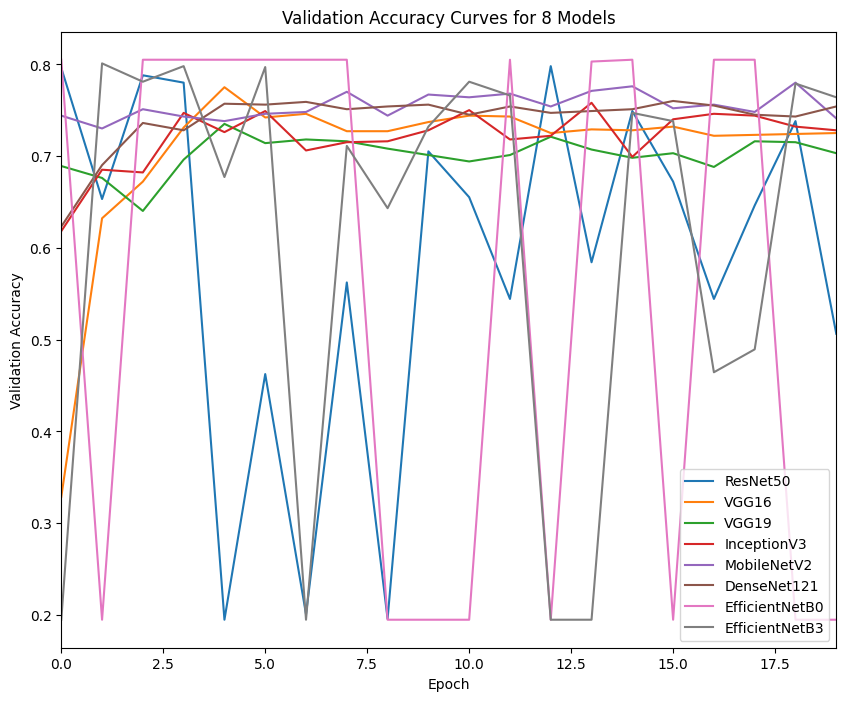

In [ ]:
import matplotlib.pyplot as plt


val_acc_resnet50 = history_resnet.history['val_accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']
val_acc_vgg19 = history_vgg19.history['val_accuracy']
val_acc_inceptionv3 = history_inceptionv3.history['val_accuracy']
val_acc_mobilenetv2 = history_mobilenetv2.history['val_accuracy']
val_acc_densenet121 = history_densenet121.history['val_accuracy']
val_acc_efficientnetb0 = history_efficientnetb0.history['val_accuracy']
val_acc_efficientnetb3 = history_efficientnetb3.history['val_accuracy']


plt.figure(figsize=(10, 8))

plt.plot(val_acc_resnet50, label='ResNet50')
plt.plot(val_acc_vgg16, label='VGG16')
plt.plot(val_acc_vgg19, label='VGG19')
plt.plot(val_acc_inceptionv3, label='InceptionV3')
plt.plot(val_acc_mobilenetv2, label='MobileNetV2')
plt.plot(val_acc_densenet121, label='DenseNet121')
plt.plot(val_acc_efficientnetb0, label='EfficientNetB0')
plt.plot(val_acc_efficientnetb3, label='EfficientNetB3')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curves for 8 Models')
plt.legend()
plt.gca().margins(x=0)  # Remove x-axis gaps

plt.savefig('Val_Accuracy_Curves.png', format='png', dpi=600, bbox_inches="tight")
plt.show()


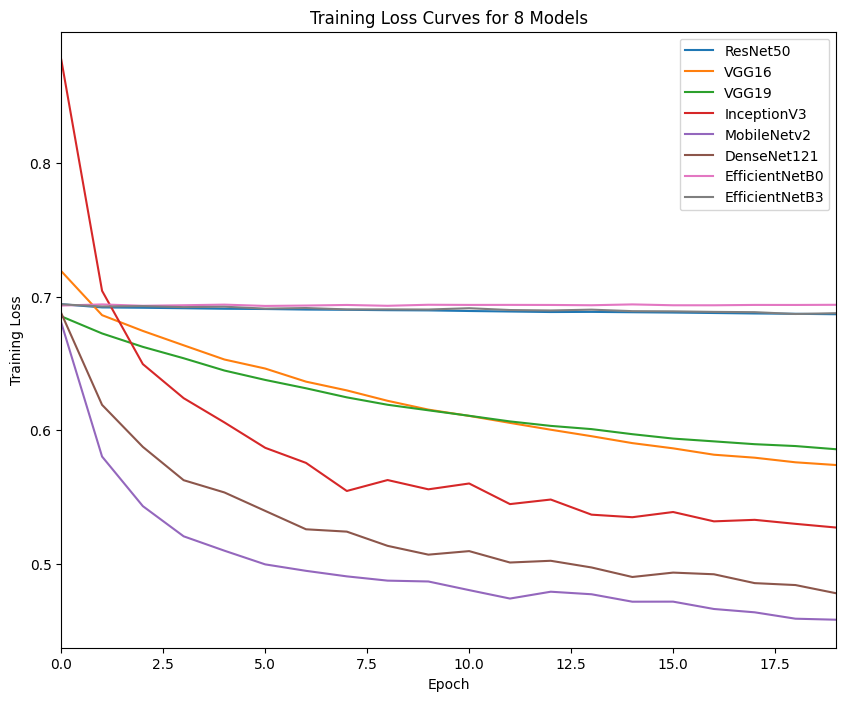

In [ ]:
import matplotlib.pyplot as plt


loss_resnet50 = history_resnet.history['loss']
loss_vgg16 = history_vgg16.history['loss']
loss_vgg19 = history_vgg19.history['loss']
loss_inceptionv3 = history_inceptionv3.history['loss']
loss_mobilenetv2 = history_mobilenetv2.history['loss']
loss_densenet121 = history_densenet121.history['loss']
loss_efficientnetb0 = history_efficientnetb0.history['loss']
loss_efficientnetb3 = history_efficientnetb3.history['loss']


plt.figure(figsize=(10, 8))

plt.plot(loss_resnet50, label='ResNet50')
plt.plot(loss_vgg16, label='VGG16')
plt.plot(loss_vgg19, label='VGG19')
plt.plot(loss_inceptionv3, label='InceptionV3')
plt.plot(loss_mobilenetv2, label='MobileNetv2')
plt.plot(loss_densenet121, label='DenseNet121')
plt.plot(loss_efficientnetb0, label='EfficientNetB0')
plt.plot(loss_efficientnetb3, label='EfficientNetB3')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves for 8 Models')
plt.legend()
plt.gca().margins(x=0)  # Remove x-axis gaps

plt.savefig('Loss_Curves.png', format='png', dpi=600, bbox_inches="tight")
plt.show()


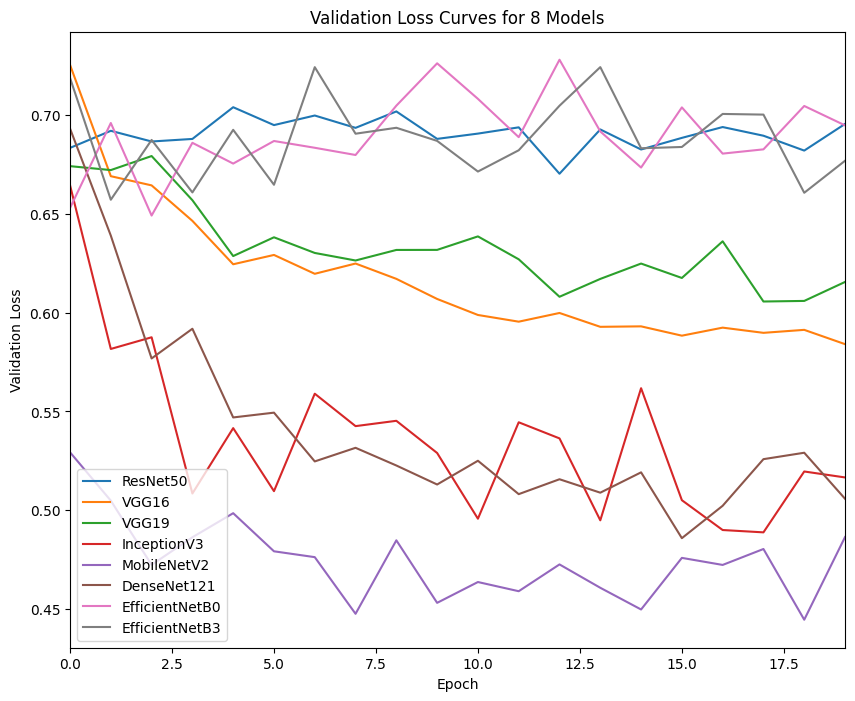

In [ ]:
import matplotlib.pyplot as plt

val_loss_resnet50 = history_resnet.history['val_loss']
val_loss_vgg16 = history_vgg16.history['val_loss']
val_loss_vgg19 = history_vgg19.history['val_loss']
val_loss_inceptionv3 = history_inceptionv3.history['val_loss']
val_loss_mobilenetv2 = history_mobilenetv2.history['val_loss']
val_loss_densenet121 = history_densenet121.history['val_loss']
val_loss_efficientnetb0 = history_efficientnetb0.history['val_loss']
val_loss_efficientnetb3 = history_efficientnetb3.history['val_loss']


plt.figure(figsize=(10, 8))

plt.plot(val_loss_resnet50, label='ResNet50')
plt.plot(val_loss_vgg16, label='VGG16')
plt.plot(val_loss_vgg19, label='VGG19')
plt.plot(val_loss_inceptionv3, label='InceptionV3')
plt.plot(val_loss_mobilenetv2, label='MobileNetV2')
plt.plot(val_loss_densenet121, label='DenseNet121')
plt.plot(val_loss_efficientnetb0, label='EfficientNetB0')
plt.plot(val_loss_efficientnetb3, label='EfficientNetB3')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Curves for 8 Models')
plt.legend()
plt.gca().margins(x=0)  # Remove x-axis gaps

plt.savefig('Val_Loss_Curves.png', format='png', dpi=600, bbox_inches="tight")
plt.show()


**DenseNet121_TL_Fusion_cbam_custom cnn**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 213MB/s]


Epoch 1/20 | Train Loss: 0.3712, Train Acc: 0.8301 | Val Loss: 0.5911, Val Acc: 0.7493
Epoch 2/20 | Train Loss: 0.2933, Train Acc: 0.8777 | Val Loss: 0.3097, Val Acc: 0.8771
Epoch 3/20 | Train Loss: 0.2263, Train Acc: 0.9091 | Val Loss: 0.3376, Val Acc: 0.8721
Epoch 4/20 | Train Loss: 0.1761, Train Acc: 0.9272 | Val Loss: 0.3697, Val Acc: 0.8921
Epoch 5/20 | Train Loss: 0.1659, Train Acc: 0.9362 | Val Loss: 0.3606, Val Acc: 0.8811
Epoch 6/20 | Train Loss: 0.1823, Train Acc: 0.9280 | Val Loss: 0.3302, Val Acc: 0.8841
Epoch 7/20 | Train Loss: 0.1080, Train Acc: 0.9616 | Val Loss: 0.3757, Val Acc: 0.8871
Epoch 8/20 | Train Loss: 0.0945, Train Acc: 0.9643 | Val Loss: 0.3616, Val Acc: 0.8971
Epoch 9/20 | Train Loss: 0.0869, Train Acc: 0.9689 | Val Loss: 0.3537, Val Acc: 0.9081
Epoch 10/20 | Train Loss: 0.0859, Train Acc: 0.9683 | Val Loss: 0.3448, Val Acc: 0.9071
Epoch 11/20 | Train Loss: 0.0702, Train Acc: 0.9763 | Val Loss: 0.3697, Val Acc: 0.9001
Epoch 12/20 | Train Loss: 0.0559, Train A

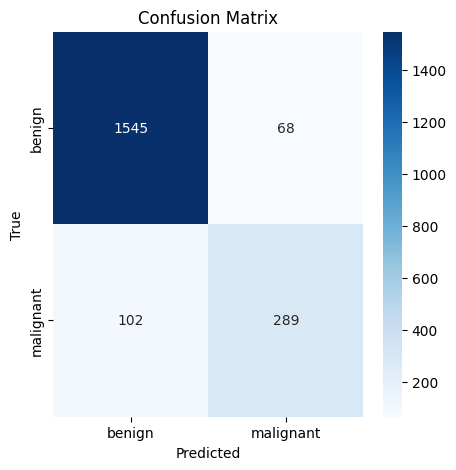

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'
image_dir_1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
image_dir_2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
metadata_csv = os.path.join(dataset_path, 'HAM10000_metadata.csv')

base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean and recreate directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

metadata = pd.read_csv(metadata_csv)

# Binary classification: benign (0) vs malignant (1)
benign_classes = ['nv', 'bkl', 'df', 'vasc']
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_classes else 1)

# Collect all image paths with label
all_images = []
for _, row in metadata.iterrows():
    img_id = row['image_id']
    label = 'malignant' if row['binary_label'] == 1 else 'benign'

    img_path = os.path.join(image_dir_1, img_id + '.jpg')
    if not os.path.exists(img_path):
        img_path = os.path.join(image_dir_2, img_id + '.jpg')

    all_images.append((img_path, label))

# Split dataset
test_split = 0.2
val_split = 0.1

train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)

val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

# Handle class imbalance
targets = [label for _, label in train_dataset.imgs]
# Extract integer labels directly
labels = [label for _, label in train_dataset.imgs]  # Already integers
class_counts = np.bincount(labels)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)



class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
        max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)
        channel_att = torch.sigmoid(self.channel_mlp(avg_pool) + self.channel_mlp(max_pool)).view(b, c, 1, 1)
        x = x * channel_att
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.sigmoid(self.spatial_conv(torch.cat([avg_out, max_out], dim=1)))
        return x * spatial_att

class FusionNet(nn.Module):
    def __init__(self, num_classes):
        super(FusionNet, self).__init__()
        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()
        out_channels = 1024

        self.cbam = CBAMBlock(out_channels)
        self.mid_cnn = nn.Sequential(
            nn.Conv2d(out_channels, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        if len(features.size()) == 2:
            features = features.view(features.size(0), -1, 1, 1)
        attn_features = self.cbam(features)
        mid_features = self.mid_cnn(attn_features)
        flat = torch.flatten(mid_features, 1)
        return self.fc(flat)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionNet(num_classes=len(train_dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter("runs/ham10000_fusion")

EPOCHS = 20

def train_model(model, train_loader, val_loader, criterion, optimizer, device, writer):
    best_val_acc = 0.0
    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        writer.add_scalars("Loss", {"train": epoch_loss, "val": val_loss}, epoch)
        writer.add_scalars("Accuracy", {"train": epoch_acc, "val": val_acc}, epoch)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

train_model(model, train_loader, val_loader, criterion, optimizer, device, writer)



model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


**Final_densenet121-fusion-cbam-prepool**

Data split complete: Train=7010, Val=1001, Test=2004
Device: cuda
Classes: ['benign', 'malignant']


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 175MB/s]


Epoch 1/40 | Time 37.7s | Train Loss 0.4536 Acc 0.7840 | Val Loss 0.7966 Acc 0.6783
Epoch 2/40 | Time 36.2s | Train Loss 0.4177 Acc 0.8027 | Val Loss 0.4252 Acc 0.7942
Epoch 3/40 | Time 36.1s | Train Loss 0.3848 Acc 0.8225 | Val Loss 0.3851 Acc 0.8192
Epoch 4/40 | Time 36.1s | Train Loss 0.3575 Acc 0.8379 | Val Loss 0.3332 Acc 0.8591
Epoch 5/40 | Time 36.1s | Train Loss 0.3509 Acc 0.8422 | Val Loss 0.5474 Acc 0.7792
Epoch 6/40 | Time 36.0s | Train Loss 0.2951 Acc 0.8740 | Val Loss 0.5155 Acc 0.7772
Epoch 7/40 | Time 35.9s | Train Loss 0.2717 Acc 0.8835 | Val Loss 0.4268 Acc 0.8242
Epoch 8/40 | Time 36.2s | Train Loss 0.2384 Acc 0.8994 | Val Loss 0.3172 Acc 0.8701
Epoch 9/40 | Time 36.0s | Train Loss 0.2218 Acc 0.9114 | Val Loss 0.3508 Acc 0.8681
Epoch 10/40 | Time 35.9s | Train Loss 0.1733 Acc 0.9318 | Val Loss 0.4263 Acc 0.8641
Epoch 11/40 | Time 35.9s | Train Loss 0.1477 Acc 0.9438 | Val Loss 0.2862 Acc 0.8971
Epoch 12/40 | Time 35.9s | Train Loss 0.1350 Acc 0.9488 | Val Loss 0.3574 

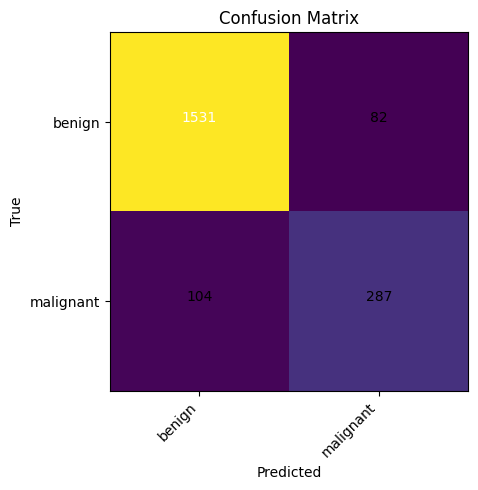

In [ ]:
import os
import math
import copy
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms, datasets

dataset_path = "/kaggle/input/skin-cancer-mnist-ham10000"

image_dir_1 = os.path.join(dataset_path, "HAM10000_images_part_1")
image_dir_2 = os.path.join(dataset_path, "HAM10000_images_part_2")
metadata_csv = os.path.join(dataset_path, "HAM10000_metadata.csv")

base_dir = "/kaggle/working/ham_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

#  CLEANUP
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)


metadata = pd.read_csv(metadata_csv)
benign_classes = ["nv", "bkl", "df", "vasc"]
metadata["binary_label"] = metadata["dx"].apply(lambda x: 0 if x in benign_classes else 1)

# Collect images
all_images = []
for _, row in metadata.iterrows():
    img_id = row["image_id"]
    label = "malignant" if row["binary_label"] == 1 else "benign"
    img_path = os.path.join(image_dir_1, img_id + ".jpg")
    if not os.path.exists(img_path):
        img_path = os.path.join(image_dir_2, img_id + ".jpg")
    all_images.append((img_path, label))

# Split dataset
train_images, temp_images = train_test_split(
    all_images,
    test_size=0.3,
    stratify=[lbl for _, lbl in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=2/3,
    stratify=[lbl for _, lbl in temp_images],
    random_state=42
)

# Copy images to directories
def copy_images(img_label_list, dest_dir):
    for img_path, label in img_label_list:
        class_dir = os.path.join(dest_dir, label)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(img_path, class_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)
print(f"Data split complete: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

img_size = 224
batch_size = 32
num_workers = 4

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
val_dataset   = datasets.ImageFolder(val_dir, transform=data_transforms["val"])
test_dataset  = datasets.ImageFolder(test_dir, transform=data_transforms["test"])

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Compute class weights
labels = [y for _, y in train_dataset.samples]
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

#  CBAM MODULE
class ChannelAttention(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16):
        super().__init__()
        hidden = max(in_channels // reduction, 1)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, in_channels, bias=False)
        )
        self.pool_avg = nn.AdaptiveAvgPool2d(1)
        self.pool_max = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg = self.pool_avg(x).view(b, c)
        mx  = self.pool_max(x).view(b, c)
        attn = self.mlp(avg) + self.mlp(mx)
        attn = self.sigmoid(attn).view(b, c, 1, 1)
        return x * attn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        feat = torch.cat([avg, mx], dim=1)
        attn = self.sigmoid(self.conv(feat))
        return x * attn

class CBAM(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16):
        super().__init__()
        self.ca = ChannelAttention(in_channels, reduction)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x))

# MODEL
class DenseNetCBAMFusion(nn.Module):
    def __init__(self, num_classes=2, unfreeze_last_block=True, mid_channels=1024):
        super().__init__()
        backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.stem = backbone.features
        in_ch = 1024
        for p in self.stem.parameters():
            p.requires_grad = False
        if unfreeze_last_block:
            for p in list(self.stem[-6:].parameters()):
                p.requires_grad = True

        self.attn = CBAM(in_ch)
        self.mid = nn.Sequential(
            nn.Conv2d(in_ch, mid_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(mid_channels, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.attn(x)
        x = self.mid(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

model = DenseNetCBAMFusion(num_classes=num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad],
                              lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

#  TRAIN / EVALUATE FUNCTIONS
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_logits, all_targets = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())
    return total_loss / total, correct / total, torch.cat(all_logits), torch.cat(all_targets)


val_acc_cbam_fusion = []
val_loss_cbam_fusion = []

#  TRAINING LOOP
best_acc = 0
best_wts = copy.deepcopy(model.state_dict())
patience = 5
epochs_no_improve = 0
epochs = 40

for epoch in range(1, epochs+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_logits, val_targets = evaluate(model, val_loader)

    # Append to lists
    val_acc_cbam_fusion.append(val_acc)
    val_loss_cbam_fusion.append(val_loss)

    scheduler.step()

    if val_acc > best_acc:
        best_acc = val_acc
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(best_wts, "best_cbam_fusion.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch}/{epochs} | Time {time.time()-t0:.1f}s | "
          f"Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | "
          f"Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

    if epochs_no_improve >= patience:
        print("Early stopping.")
        break

# Load best model
model.load_state_dict(best_wts)

test_loss, test_acc, test_logits, test_targets = evaluate(model, test_loader)
print(f"TEST | Loss {test_loss:.4f} Acc {test_acc:.4f}")

def plot_confusion_matrix(logits, targets, classes):
    preds = logits.argmax(dim=1).numpy()
    y_true = targets.numpy()
    cm = confusion_matrix(y_true, preds, labels=list(range(len(classes))))

    fig = plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Add counts
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_logits, test_targets, class_names)
